In [141]:
!pip install pulp

In [142]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import matplotlib.pyplot as plt
import time
import random
import numpy as np  # For any potential mathematical computations not shown here

# Define Constraints
constraints_list = [
    {"D": 6, "Q": 5, "E": 4},
    {"D": 4, "Q": 3, "E": 6},
    {"D": 5, "Q": 5, "E": 5}
]

# Define datasets
datasets = [
    {
        "description": "Dataset 1 (Small dataset)",
        "data": pd.DataFrame({
            "S": ["(1,2)", "(2,3)", "(3,4)", "(4,5)"],
            "i": [1, 2, 3, 4],
            "j": [2, 3, 4, 5],
            "Q": [8, 6, 7, 9],
            "E": [7, 5, 6, 8],
            "D": [3, 4, 5, 6]
        })
    },
    {
        "description": "Dataset 2 (Large dataset)",
        "data": pd.DataFrame({
            "S": [
                "(1,2)", "(1,3)", "(1,4)", "(2,3)", "(2,5)", "(3,4)", "(3,6)", "(4,5)", "(4,7)", "(5,6)",
                "(5,8)", "(6,7)", "(6,9)", "(7,8)", "(8,9)", "(8,10)", "(9,10)", "(9,11)", "(10,11)", "(11,12)",
                "(12,13)", "(13,14)", "(14,15)", "(15,16)", "(16,17)", "(17,18)", "(18,19)", "(19,20)", "(20,21)"
            ],
            "i": [1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
            "j": [2, 3, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 9, 10, 10, 11, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
            "Q": [8, 7, 6, 5, 9, 6, 8, 7, 9, 8, 7, 9, 6, 8, 7, 9, 8, 7, 9, 8, 7, 9, 8, 7, 9, 8, 7, 9, 8],
            "E": [7, 6, 5, 4, 8, 5, 7, 6, 8, 7, 6, 8, 5, 7, 6, 8, 7, 6, 8, 7, 6, 8, 7, 6, 8, 7, 6, 8, 7],
            "D": [3, 2, 4, 5, 6, 4, 3, 5, 6, 4, 5, 3, 4, 5, 3, 4, 5, 3, 4, 5, 3, 4, 5, 3, 4, 5, 3, 4, 5]
        })
    }
]

# Define weights
w1, w2, w3 = 0.2, 0.6, 0.7


In [143]:
def linear_programming(df, constraint):
    start_time = time.time()
    prob = LpProblem("Flood_Route_Optimization", LpMaximize)
    df['x'] = [LpVariable(f"x_{i}_{j}", cat="Binary") for i, j in zip(df['i'], df['j'])]

    # Define the objective function
    prob += lpSum((w1 * row['Q'] + w2 * row['E'] - w3 * row['D']) * row['x'] for _, row in df.iterrows()), "Objective"

    # Add constraints
    for _, row in df.iterrows():
        if row['D'] > constraint['D']:
            prob += row['x'] == 0
        if row['Q'] < constraint['Q']:
            prob += row['x'] == 0
        if row['E'] < constraint['E']:
            prob += row['x'] == 0

    # Flow constraints for nodes
    nodes = set(df['i']).union(set(df['j']))
    for node in nodes:
        outgoing = df.loc[df['i'] == node, 'x']
        incoming = df.loc[df['j'] == node, 'x']
        if node == 1:
            prob += lpSum(outgoing) == 1
        elif node == max(nodes):
            prob += lpSum(incoming) == 1
        else:
            prob += lpSum(outgoing) - lpSum(incoming) == 0

    # Solve the problem
    prob.solve()
    time_elapsed = time.time() - start_time

    # Get the optimized routes
    df['Selected'] = [var.value() for var in df['x']]
    optimized_routes = df[df['Selected'] == 1]

    return optimized_routes, time_elapsed

In [144]:
def simulated_annealing(df, start_node, end_node, constraint, max_iter=100, temp=10, cooling_rate=0.80):
    def calculate_route_score(route, df):
        return sum(
            w1 * df.loc[idx, 'Q'] + w2 * df.loc[idx, 'E'] - w3 * df.loc[idx, 'D']
            for idx in route
        )

    start_time = time.time()

    # Filter routes that satisfy the constraints
    valid_routes = df[
        (df['D'] <= constraint['D']) &
        (df['Q'] >= constraint['Q']) &
        (df['E'] >= constraint['E'])
    ].index.tolist()

    if not valid_routes:
        return [], float('inf')  # Return an empty route if no valid routes

    current_route = random.sample(valid_routes, min(len(valid_routes), 5))
    best_route = current_route[:]
    best_score = calculate_route_score(best_route, df)

    while temp > 1 and max_iter > 0:
        # Create a new route by tweaking the current route
        new_route = current_route[:]
        if len(new_route) > 1:
            i, j = random.sample(range(len(new_route)), 2)
            new_route[i], new_route[j] = new_route[j], new_route[i]

        # Calculate the score of the new route
        new_score = calculate_route_score(new_route, df)

        # Accept the new route if it's better or with a probability based on temperature
        if new_score > best_score or random.uniform(0, 1) < np.exp((new_score - best_score) / temp):
            current_route = new_route
            best_score = new_score

        # Update the best route if the new one is better
        if best_score > calculate_route_score(best_route, df):
            best_route = current_route

        # Cool down and decrement iteration count
        temp *= cooling_rate
        max_iter -= 1

    time_elapsed = time.time() - start_time
    return best_route, time_elapsed


In [145]:
# Processing datasets with exact and simulated annealing methods
for constraint in constraints_list:
    print(f"Results for Constraint: {constraint}")
    for dataset in datasets:
        data = dataset["data"]

        # Exact Method
        optimized_routes, exact_time = linear_programming(data, constraint)
        print(f"Linear Programming Results for {dataset['description']}:")
        print(optimized_routes)
        print(f"Execution Time (Linear Programming): {exact_time:.4f} seconds")

        # Simulated Annealing
        optimized_route, sa_time = simulated_annealing(data, start_node=1, end_node=8, constraint=constraint)
        print(f"\nSimulated Annealing Results for {dataset['description']}:")
        print(f"Optimized Route Indices: {optimized_route}")
        print(f"Execution Time (Simulated Annealing): {sa_time:.4f} seconds")
        print("----------------------------------------------------")

Results for Constraint: {'D': 6, 'Q': 5, 'E': 4}
Linear Programming Results for Dataset 1 (Small dataset):
       S  i  j  Q  E  D      x  Selected
0  (1,2)  1  2  8  7  3  x_1_2       1.0
1  (2,3)  2  3  6  5  4  x_2_3       1.0
2  (3,4)  3  4  7  6  5  x_3_4       1.0
3  (4,5)  4  5  9  8  6  x_4_5       1.0
Execution Time (Linear Programming): 0.0152 seconds

Simulated Annealing Results for Dataset 1 (Small dataset):
Optimized Route Indices: [2, 0, 3, 1]
Execution Time (Simulated Annealing): 0.0052 seconds
----------------------------------------------------
Linear Programming Results for Dataset 2 (Large dataset):
          S   i   j  Q  E  D        x  Selected
0     (1,2)   1   2  8  7  3    x_1_2       1.0
3     (2,3)   2   3  5  4  5    x_2_3       1.0
5     (3,4)   3   4  6  5  4    x_3_4       1.0
7     (4,5)   4   5  7  6  5    x_4_5       1.0
9     (5,6)   5   6  8  7  4    x_5_6       1.0
11    (6,7)   6   7  9  8  3    x_6_7       1.0
13    (7,8)   7   8  8  7  5    x_7_8 

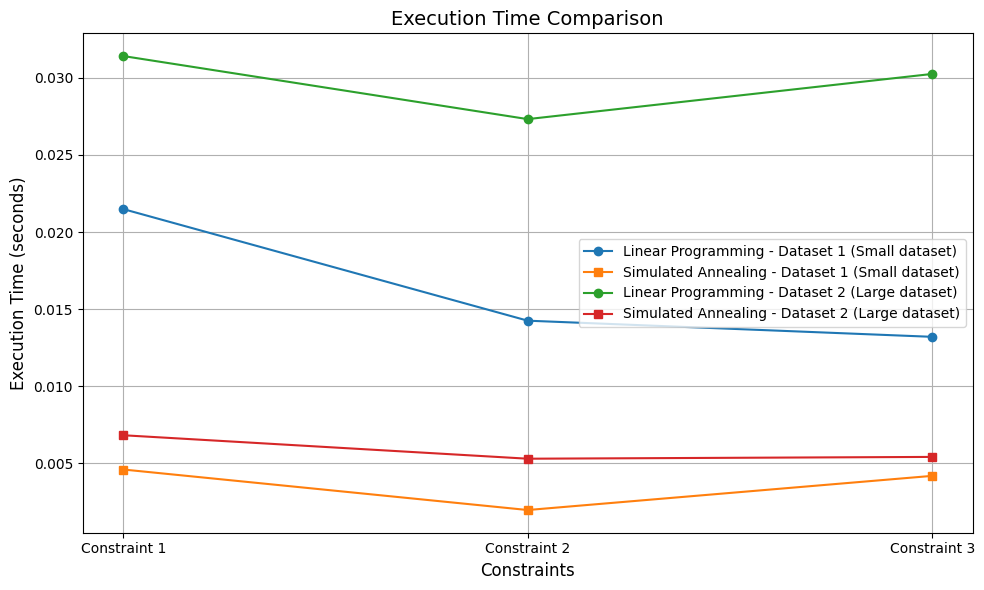

In [146]:
# Process datasets with exact and simulated annealing methods
exact_times = []
sa_times = []

for dataset in datasets:
    dataset_exact_times = []
    dataset_sa_times = []
    for constraint in constraints_list:
        data = dataset["data"]

        # Exact Method
        _, exact_time = linear_programming(data, constraint)
        dataset_exact_times.append(exact_time)

        # Simulated Annealing
        _, sa_time = simulated_annealing(data, start_node=1, end_node=8, constraint=constraint)
        dataset_sa_times.append(sa_time)

    exact_times.append(dataset_exact_times)
    sa_times.append(dataset_sa_times)

# Plotting the data
constraints_labels = [f"Constraint {i+1}" for i in range(len(constraints_list))]
datasets_labels = [dataset["description"] for dataset in datasets]

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(constraints_list))

# Plot execution times for each dataset
for idx, dataset_label in enumerate(datasets_labels):
    ax.plot(x, exact_times[idx], label=f"Linear Programming - {dataset_label}", marker='o')
    ax.plot(x, sa_times[idx], label=f"Simulated Annealing - {dataset_label}", marker='s')

# Adding title, labels, and legend
ax.set_title("Execution Time Comparison", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(constraints_labels)
ax.set_xlabel("Constraints", fontsize=12)
ax.set_ylabel("Execution Time (seconds)", fontsize=12)
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()
